In [1]:
import torch
import torch.nn as nn  # 뉴럴 네트워크 - 모델 클래스를 만드는데 쓴다.
import torch.nn.functional as F   #활성화함수 시그모이드, 함수 소프트맥스가 들어있다.

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets   # 컴퓨터 비젼 분야에서 많이 쓴다.

In [2]:
# GPU를 사용하기 위해서
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print(DEVICE)

cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
transform_setting = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="../data/MNIST", train = True, download=True,transform=transform_setting)
test_dataset = datasets.MNIST(root="../data/MNIST", train=False, transform=transform_setting)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [5]:
# 데이터 확인해 보기
for X_train, Y_train in train_loader:
    print(X_train.size(), ", " , X_train.type())
    print(Y_train.size(), ", " , Y_train.type())
    break
    
# 28*28크기에 kernal이 1인 이미지 32개가 하나의 미니배치를 구성한다.

torch.Size([32, 1, 28, 28]) ,  torch.FloatTensor
torch.Size([32]) ,  torch.LongTensor


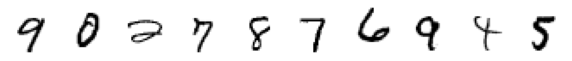

In [6]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")

In [12]:
# 모델 설계

class MLP_model(nn.Module):    # nn.Module 클래스를 상속 받는다.(딥러닝과 관련된 기본 함수들을 쓰기 위해)
    def __init__(self):
        super(MLP_model,self).__init__()    # 상속작업후, 은닉층에 해당하는 layer를 설정해 준다(하이퍼 파라미터)
        self.layer1 = nn.Linear(1*28*28, 512)  # nn.Linear함수는 저장된 가중치와 편향을 사용하여 입력을 선형변환해 주는 모듈
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 10)  # 시작과 끝을 잘 봐야한다!!
        
        self.dropout = 0.2 # 에포크 마다 랜덤하게 20% 노드를 droupout한다.
        
        # nn.Sequential() 을 이용한 layer 묶기 설명
        
    def forward(self, x):
        x = x.view(-1,1*28*28)
        x = self.layer1(x)
        #x = F.sigmoid(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout)  #traing 부분은 train에서는 실행, test에서는 사용 안하기 위해서
        x = self.layer2(x)
        #x = F.sigmoid(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout)
        x = self.layer3(x)
        x = F.log_softmax(x, dim=1)
        
        return x


In [13]:
model = MLP_model().to(DEVICE)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.5) # 옵티마이저=최적화 함수 를 SGD로 설정
loss_func = nn.CrossEntropyLoss()  # 손실함수를 크로스엔트로피 손실함수로 설정 -> 로지스틱 손실함수때 나왔다!!

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [14]:
"""
train 순서
1. 옵티마이저 초기화 
2. output 값을 추출 -> image를 모델에 넣어 은닉층을 거쳐서 z값을 뽑아냄
3. loss 값을 뽑아낸다.
4. loss값으로 역전파 수행
5. 옵티마이저 진행 -> 경사하강법으로 적절히 이동
"""

def train(model, train_loader, optimizer, log_interval):
    model.train()  #기존에 정의한 MLP 모델을 '학습상태' 로 지정한다.
    for batch_idx, (image, label) in enumerate(train_loader):   # enumerate설명 
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(image)
        
        loss = loss_func(output, label)
        loss.backward()
        
        optimizer.step()

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += loss_func(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. *correct/len(test_loader.dataset)
        return test_loss, test_accuracy

In [16]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[Epoch: {}],  test_loss: {}    accuracy: {:.2f}%".format(Epoch, test_loss, test_accuracy))


[Epoch: 1],  test_loss: 0.009751455055177211    accuracy: 91.28%

[Epoch: 2],  test_loss: 0.0068607915395405145    accuracy: 93.61%

[Epoch: 3],  test_loss: 0.005396268725185655    accuracy: 94.85%

[Epoch: 4],  test_loss: 0.004452006072539371    accuracy: 95.65%

[Epoch: 5],  test_loss: 0.003765117732214276    accuracy: 96.25%

[Epoch: 6],  test_loss: 0.0032785067806195    accuracy: 96.82%

[Epoch: 7],  test_loss: 0.002957085181819275    accuracy: 96.98%

[Epoch: 8],  test_loss: 0.002780039426009171    accuracy: 97.27%

[Epoch: 9],  test_loss: 0.0025288449851417682    accuracy: 97.46%

[Epoch: 10],  test_loss: 0.0023898702631064226    accuracy: 97.56%

[Epoch: 11],  test_loss: 0.0022797252841293813    accuracy: 97.81%

[Epoch: 12],  test_loss: 0.0022425745632644978    accuracy: 97.74%

[Epoch: 13],  test_loss: 0.002113379146489024    accuracy: 97.84%

[Epoch: 14],  test_loss: 0.0021213719390652842    accuracy: 97.96%

[Epoch: 15],  test_loss: 0.0019695457566791448    accuracy: 97.94%